<a href="https://colab.research.google.com/github/gmb408/OSSP-KBO-prediction/blob/main/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [ ]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [ ]:
# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
submission = pd.read_csv("/content/submission.csv")
result = pd.read_csv("/content/statiz_v2.csv", index_col=0)
reg = pd.read_csv("/content/Regular_Season_Batter.csv")


In [ ]:
df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['OPS_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)

In [ ]:
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환

In [ ]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','도루','도실','볼넷','사구','고4','삼진'\
        ,'병살','희타','희비','타율','출루','장타','OPS']

In [ ]:
# 누적 및 lag stat features 이름
stats_cum = [i + '_누적' for i in stats]
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [ ]:
# X features와 y feature 정리
stats_position = ['2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS']
X_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_position + ['나이']
y_cols = ['OPS_NEXT']

In [ ]:
# 학습시킬 모델
model_dict = {'xgb':XGBRegressor(n_estimators=110, learning_rate=0.05 ,max_depth=3, min_samples_split=400, random_state=23),
              'lgbm':LGBMRegressor(),
              'rf':RandomForestRegressor(),
              'svr':SVR(),
              'knn':KNeighborsRegressor(),
              'reg':LinearRegression(),
              'ridge':Ridge(),
              }


In [24]:
# 2009 ~ 2016년 기간의 데이터로 검증
# 예를들어 2010년은 2009년까지의 데이터로, 2011년은 2010년까지의 데이터로 검증
# 에러가 가장 낮은 두 모델, xgboost와 ridge 중 ridge 선택
# ridge가 xgboost에 비해 과적합이 적고 일반화가 더 잘 이뤄졌을 것이라는 판단
from sklearn.ensemble import GradientBoostingRegressor
test_error = []
r2 = []



for year in range(2010, 2018):

    train = df[df['시즌'] < year-1].reset_index(drop=True)
    test = df[df['시즌'] == year-1].reset_index(drop=True)
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    
    model = model_dict['xgb']    #모델명 바꾸어 가면서 실험 가능
    weight = train['타수']
    model.fit(X_train, y_train, sample_weight=weight)
    y_predict = model.predict(X_test)
    test_error.append(mean_squared_error(y_test, y_predict, sample_weight=X_test['타수']) ** 0.5)

    clear_output(wait=True)
    print(year, ": 완료")
    
    
print("test error : ", np.mean(test_error))
print("RMSE : ", np.std(test_error))
print("r2 : ", np.mean(r2))
print("완료")

2017 : 완료
test error :  0.09317748161481834
RMSE :  0.0151709850562135
r2 :  nan
완료


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# 연도별 테스트 에러
test_error

[0.10757709252958779,
 0.10825258644669822,
 0.13549001735235355,
 0.10875175073894792,
 0.11746390204987826,
 0.12314584990259564,
 0.12015757975758846,
 0.11385251922502354,
 0.11951991178002243,
 0.13566793547136838,
 0.11711369335063046,
 0.1007524868051699,
 0.10823091476936884,
 0.11525585497954177,
 0.157533833217977,
 0.12301107292149403,
 0.14350463145598516,
 0.12245968793958166,
 0.11795731676480589]

(0.0, 1.5)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text

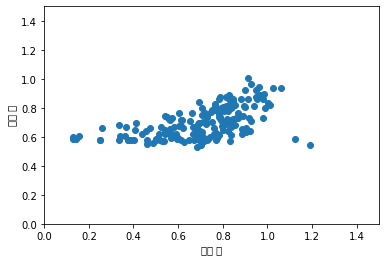

In [ ]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, y_predict)
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.xlim(0,1.5)
plt.ylim(0,1.5)

In [ ]:
predict = result[result['시즌']==2018] # 2018년도 데이터 프레임
predict = pd.concat([predict, pd.get_dummies(predict['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환

In [ ]:
# Dacon regular season과 submission 병합
# 추후 statiz data와 병합할 때 기준이 되는 생일 데이터를 얻기 위함
reg_sub = pd.merge(submission, reg[reg['year']==2018], on='batter_id', how='left', suffixes=['','_reg'])

In [ ]:

# regular season dataframe의 생일 데이터를 statiz와 일치시킴
reg_sub['year_born'] = reg_sub['year_born'].apply(lambda x: datetime.strptime(x, "%Y년 %m월 %d일").date())
reg_sub['year_born'] = reg_sub['year_born'].astype(str)

In [ ]:
# 필요한 feature만 남김
reg_sub = reg_sub[['batter_name', 'year_born', 'batter_id']]

In [ ]:
# 이름과 생일을 기준으로 dacon data와 statiz data 병합
total = pd.merge(reg_sub, predict, how='left', left_on=['batter_name', 'year_born'], right_on=['이름', '생일'])


In [ ]:
X = total[X_cols] # 사용 feature
X = X.fillna(-1) # NA값 -1로 impute

In [ ]:
# 예측
total['y_hat'] = model.predict(X)
total['dddd'] = model.predict(X)

In [ ]:
# 타자별 예측값 feature에 저장
submission['batter_ops'] = submission['batter_id'].apply(lambda x: total[total['batter_id']==x]['y_hat'].values[0])

In [ ]:
# 제출 파일 생성
submission.to_csv("/content/tnt_submission.csv", index=False, encoding='utf-8')

In [ ]:

# 제출 결과 확인
sub = pd.read_csv('/content/tnt_submission.csv')
sub

,batter_id,batter_name,batter_ops
0,1,강경학,0.672230
1,2,강구성,0.576039
2,3,강민국,0.576039
3,4,강민호,0.825121
4,5,강백호,0.857942
...,...,...,...
215,337,홍재호,0.591734
216,338,홍창기,0.585204
217,341,황윤호,0.549729
218,342,황재균,0.853627
